In [4]:
import sys
import matplotlib.pyplot as plt
import pandas as pd
import os

In [6]:
os.chdir("/home2/s439906/project/CASP16/monomer")

Processing T1270-D2.csv
Processing T1271s3-D1.csv
Processing T1259-D1.csv
Processing T1231-D1.csv
Processing T1271s7-D1.csv
Processing T1244s1-D1.csv
Processing T1245s1-D1.csv
Processing T1218-D3.csv
Processing T1280-D1.csv
Processing T1270-D1.csv
Processing T1269-D2.csv
Processing T1271s4-D1.csv
Processing T1279-D1.csv
Processing T1206-D1.csv
Processing T1276-D1.csv
Processing T1292-D1.csv
Processing T1257.csv
Processing T1207-D1.csv
Processing T1239-D2-all.csv
Processing T1249v1-D1.csv
Processing T1228-D2-all.csv
Processing T1274-D1.csv
Processing T1271s5-D2.csv
Processing T1267s1-D2.csv
Processing T1201.csv
Processing T1218-D1.csv
Processing T1298-D1.csv
Processing T1272s6-D1.csv
Processing T1220s1.csv
Processing T1272s8-D1.csv
Processing T1271s8-D2.csv
Processing T1267s2-D1.csv
Processing T1246-D1.csv
Processing T1212-D1.csv
Processing T1210.csv
Processing T1234-D1.csv
Processing T1235-D1.csv
Processing T1240-D2.csv
Processing T1243-D1.csv
Processing T1284-D1.csv
Processing T1294-D

SystemExit: 0

/home2/s439906/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3351: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


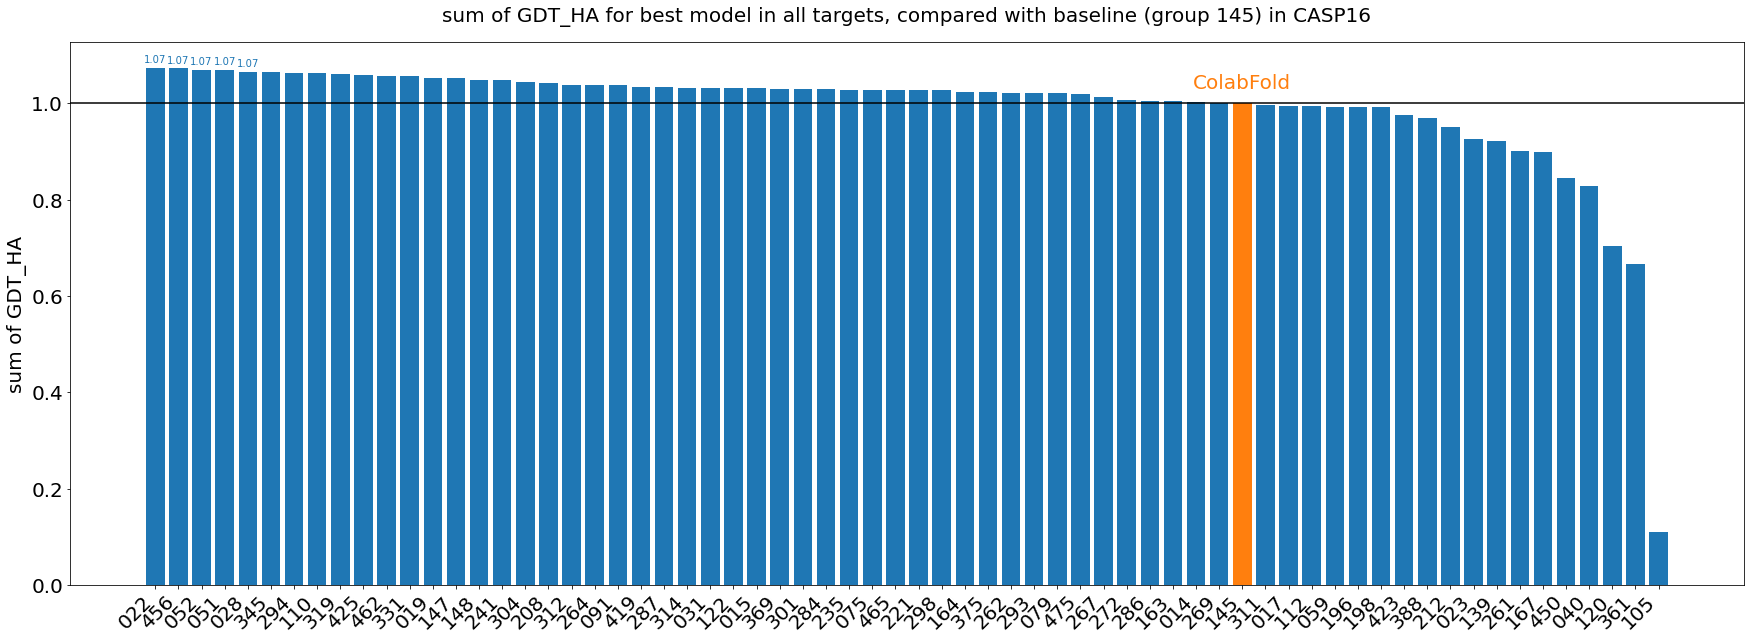

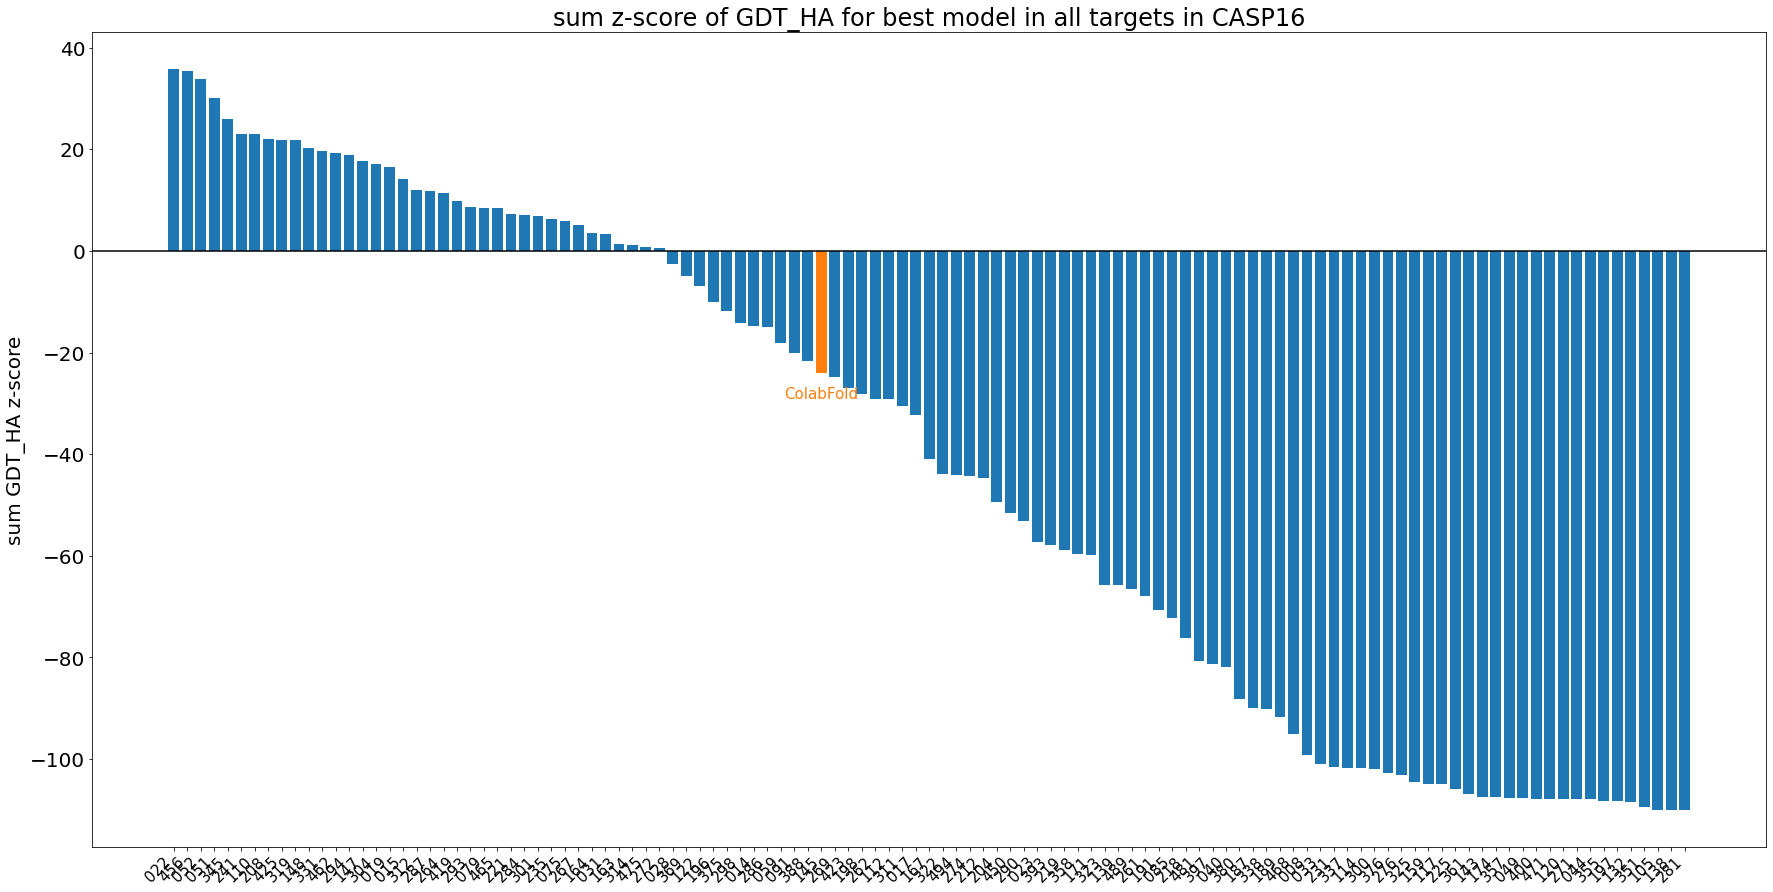

In [7]:
# csv_path = "./monomer_data_aug_30/processed/EU/"
# csv_path = "./monomer_data_Sep_10/processed/EU/"
# csv_path = "./monomer_data_Sep_10/raw_data/EU/"
csv_path = "./monomer_data_Sep_15_EU/raw_data/"
# baseline_path = "./baseline_data_Sep_15_EU/raw_data/"
csv_list = [txt for txt in os.listdir(
    csv_path) if txt.endswith(".csv") and txt.startswith("T1")]
out_path = "./group_by_target/"
sum_path = "./sum/"
png_path = "./png/"

# out_path = "./group_by_target/"
# sum_path = "./sum/"
if not os.path.exists(out_path):
    os.makedirs(out_path)
if not os.path.exists(sum_path):
    os.makedirs(sum_path)
if not os.path.exists(png_path):
    os.makedirs(png_path)

model = "first"
model = "best"

mode = "easy"
mode = "medium"
mode = "hard"
mode = "all"



# print(csv_list.__len__())
# breakpoint()
# read all data and concatenate them into one big dataframe
feature = "GDT_TS"
feature = "GDT_HA"
features = ['GDT_TS',
            'GDT_HA', 'GDC_SC', 'GDC_ALL', 'RMS_CA', 'RMS_ALL', 'AL0_P',
            'AL4_P', 'ALI_P', 'LGA_S', 'RMSD[L]', 'MolPrb_Score', 'LDDT',
            'SphGr',
            'CAD_AA', 'RPF', 'TMscore', 'FlexE', 'QSE', 'CAD_SS', 'MP_clash',
            'MP_rotout', 'MP_ramout', 'MP_ramfv', 'reLLG_lddt', 'reLLG_const']

inverse_columns = ["RMS_CA", "RMS_ALL", "err",
                   "RMSD[L]", "MolPrb_Score", "FlexE", "MP_clash", "MP_rotout", "MP_ramout"]


def get_group_by_target(csv_list, csv_path, feature, model, mode):
    data = pd.DataFrame()
    data_raw = pd.DataFrame()  # store raw data for analysis
    for csv_file in csv_list:
        print("Processing {}".format(csv_file))
        data_tmp = pd.read_csv(csv_path + csv_file, index_col=0)
        data_tmp = pd.DataFrame(data_tmp[feature])
        # there is a BUG here. something wrong with group 999 processing but I don't have time to fix it.
        # so just leave it here as it is, since I even know which group is colabfold lol :D
        data_tmp = data_tmp.replace("-", float(0))
        if feature in inverse_columns:
            data_tmp[feature] = -data_tmp[feature]
        data_tmp.index = data_tmp.index.str.extract(
            r'(T\w+)TS(\w+)_(\w+)-(D\w+)').apply(lambda x: (f"{x[0]}-{x[3]}", f"TS{x[1]}", x[2]), axis=1)
        data_tmp.index = pd.MultiIndex.from_tuples(
            data_tmp.index, names=['target', 'group', 'submission_id'])
        # # get all data with submission_id == 6
        # data_tmp = data_tmp.loc[(slice(None), slice(None), "6"), :]
        # drop all data with submission_id == 6
        if model == "best":
            data_tmp = data_tmp.loc[(slice(None), slice(None), [
                "1", "2", "3", "4", "5"]), :]  # remove 6
        elif model == "first":
            data_tmp = data_tmp.loc[(slice(None), slice(None),
                                     "1"), :]
        grouped = data_tmp.groupby(["group"])
        grouped = pd.DataFrame(grouped[feature].max())
        # grouped.index = grouped.index.droplevel(1)
        # if there is any value in this column that is a string, convert it to float
        grouped[feature] = grouped[feature].astype(float)
        try:
            grouped = grouped.sort_values(by=feature, ascending=False)
            # print all the value in grouped
            # for i in range(grouped.shape[0]):print(grouped.iloc[i])
            initial_z = (grouped - grouped.mean()) / grouped.std()
        except:
            breakpoint()
        new_z_score = pd.DataFrame(
            index=grouped.index, columns=grouped.columns)
        filtered_data = grouped[feature][initial_z[feature] >= -2]
        new_mean = filtered_data.mean(skipna=True)
        new_std = filtered_data.std(skipna=True)
        new_z_score[feature] = (grouped[feature] - new_mean) / new_std
        new_z_score = new_z_score.fillna(-2.0)
        new_z_score = new_z_score.where(new_z_score > -2, -2)

        # I actually don't understand why this is necessary... but need to keep it in mind.
        # grouped = grouped.apply(lambda x: (x - x.mean()) / x.std())

        new_z_score = new_z_score.rename(
            columns={feature: csv_file.split(".")[0]})
        grouped = grouped.rename(
            columns={feature: csv_file.split(".")[0]})
        data = pd.concat([data, new_z_score], axis=1)
        data_raw = pd.concat([data_raw, grouped], axis=1)

    # breakpoint()
    # impute data again with -2
    data = data.fillna(-2.0)
    # sort columns by alphabetical order
    data = data.reindex(sorted(data.columns), axis=1)
    data_columns = data.columns
    data.to_csv(
        out_path + "group_by_target_baseline-{}-{}-{}.csv".format(feature, model, mode))

    target_count = {}
    for EU in data_columns:
        target = EU.split("-")[0]
        if target not in target_count:
            target_count[target] = 0
        target_count[target] += 1
    # use the inverse of the target_count as the weight
    target_weight = {key: 1/value for key, value in target_count.items()}
    # assign EU_weight based on the target_weight
    EU_weight = {EU: target_weight[EU.split("-")[0]]
                 for EU in data_columns}

    data["sum"] = data.sum(axis=1)
    data = data.sort_values(by="sum", ascending=False)
    data.to_csv(sum_path
                + "sum_unweighted_baseline_{}-{}-{}.csv".format(feature, model, mode))

    data.drop(columns=["sum"], inplace=True)
    # assign the weight to the data
    data = data * pd.Series(EU_weight)
    data["sum"] = data.sum(axis=1)
    data = data.sort_values(by="sum", ascending=False)
    data.to_csv(sum_path
                + "sum_baseline_{}-{}-{}.csv".format(feature, model, mode))

    # get the lowest value in the data_raw, and impute nan with the lowest value
    # data_raw = data_raw.fillna(data_raw.min().min())
    data_raw = data_raw.reindex(sorted(data_raw.columns), axis=1)
    data_raw["sum"] = data_raw.sum(axis=1)
    data_raw = data_raw.sort_values(by="sum", ascending=False)
    data_raw.to_csv(sum_path
                    + "sum_raw_unweighted_baseline_{}-{}-{}.csv".format(feature, model, mode))

    data_raw.drop(columns=["sum"], inplace=True)
    data_raw_weighted = data_raw * pd.Series(EU_weight)
    data_raw_weighted["sum"] = data_raw_weighted.sum(axis=1)
    data_raw_weighted = data_raw_weighted.sort_values(
        by="sum", ascending=False)
    data_raw_weighted.to_csv(sum_path
                             + "sum_raw_baseline_{}-{}-{}.csv".format(feature, model, mode))
    return data, data_raw


data, data_raw = get_group_by_target(
    csv_list, csv_path, feature, model, mode)

###############
# print the nan rate of the data in columns and rows
print(data_raw.isna().sum(axis=0)/data_raw.shape[0])
print(data_raw.isna().sum(axis=1)/data_raw.shape[1])
# remove rows with more than 50% nan values
data_raw = data_raw[data_raw.isna().sum(axis=1) < 0.5 * data_raw.shape[1]]
print(data_raw.isna().sum(axis=0)/data_raw.shape[0])
print(data_raw.isna().sum(axis=1)/data_raw.shape[1])
# for each row, get its non-nan values in intersection with "TS145", and calculate the sum of the non-nan values
# then divide the sum of the non-nan values by the sum of "TS145" to get the normalized sum
# then plot the normalized sum
data_raw = data_raw.T

groups = data_raw.columns
baseline_group = pd.DataFrame(data_raw["TS145"])
baseline_dict = {}
for group in groups:
    data_raw_group = pd.DataFrame(data_raw[group])
    # get the intersection of non nan values in data_raw_group and baseline_group
    non_nan_baseline = baseline_group[pd.notna(baseline_group["TS145"])].index
    non_nan_group = data_raw_group[pd.notna(data_raw_group[group])].index
    # 计算两者的交集
    intersection_index = non_nan_baseline.intersection(non_nan_group)
    # 根据 intersection_index 获取对应的值
    baseline_values = baseline_group.loc[intersection_index, "TS145"]
    group_values = data_raw_group.loc[intersection_index, group]

    # sum them up
    sum_baseline = baseline_values.sum()
    sum_group = group_values.sum()
    ratio = sum_group / sum_baseline
    baseline_dict[group] = ratio
    # # 输出结果或进行进一步操作
    # print(
    #     f"Group {group} has {len(intersection_index)} intersecting non-NaN values.")
    # print("Baseline values:", baseline_values.values)
    # print(f"{group} values:", group_values.values)

# sort the baseline_dict by its values
baseline_dict = dict(sorted(baseline_dict.items(),
                     key=lambda x: x[1], reverse=True))
groups = [key[2:] for key in baseline_dict.keys()]
values = list(baseline_dict.values())


plt.figure(figsize=(30, 10))
highlight_group = "145"
bar_colors = ['C0' if group != highlight_group else 'C1' for group in groups]
plt.bar(groups, values, color=bar_colors)
plt.xticks(rotation=45, fontsize=20, ha='right')
plt.yticks(fontsize=20)
plt.title(
    "sum of {} for {} model in {} targets, compared with baseline (group {}) in CASP16".format(feature, model, mode, highlight_group), fontsize=20, pad=20)
plt.ylabel("sum of {}".format(feature), fontsize=20)
plt.axhline(y=1, color='k')
# there is one group 145, we need to write something on top of its bar
for group, value in zip(groups, values):
    if group == highlight_group:
        plt.text(group, value + 0.03, str("ColabFold"),
                 ha='center', fontsize=20, color='C1')
# first 5 groups
first_5_groups = groups[:5]
first_5_values = values[:5]
for group, value in zip(first_5_groups, first_5_values):
    plt.text(group, value + 0.01, str(value.round(2)),
             ha='center', fontsize=10, color='C0')
plt.savefig(
    png_path + "sum_intersect_{}-{}-{}_with_colabfold_baseline.png".format(feature, model, mode), dpi=300)
###############

# breakpoint()
# for feature in features:
#     get_group_by_target(csv_list, csv_path, feature, model, mode)
#     print("Finished processing {}".format(feature))
data_sum = data["sum"]
# plot the data_sum
# remove the first 2 char in the index
data_sum.index = data_sum.index.str[2:]
plt.figure(figsize=(30, 15))
highlight_index = "145"
bar_colors = ['C0' if index !=
              highlight_index else 'C1' for index in data_sum.index]

plt.bar(data_sum.index, data_sum.values, color=bar_colors)
plt.xticks(rotation=45, fontsize=15, ha='right')
plt.yticks(fontsize=20)
plt.title(
    "sum z-score of {} for {} model in {} targets in CASP16".format(feature, model, mode), fontsize=24)
plt.ylabel(f"sum {feature} z-score", fontsize=20)
plt.axhline(y=0, color='k')
# there is one group 145, we need to write something on top of its bar

for index, value in zip(data_sum.index, data_sum.values):
    if index == highlight_index:
        plt.text(index, value - 5, str("ColabFold"),
                 ha='center', fontsize=15, color='C1')
plt.savefig(
    png_path + "sum_z-score_{}-{}-{}.png".format(feature, model, mode), dpi=300)
# plt.axvline(x="145", color='r')

sys.exit(0)

###############
# divide by the sum of 145
data_raw_sum = data_raw["sum"]
data_raw_sum.index = data_raw_sum.index.str[2:]
# want to normalize the data_raw_sum by the sum of group 145
data_raw_sum = data_raw_sum / data_raw_sum["145"]
plt.figure(figsize=(30, 15))
highlight_index = "145"
bar_colors = ['C0' if index !=
              highlight_index else 'C1' for index in data_raw_sum.index]
plt.bar(data_raw_sum.index, data_raw_sum.values, color=bar_colors)
plt.xticks(rotation=45, fontsize=12, ha='right')
plt.title(
    "sum of {} for {} model in {} targets, compared with baseline (group {})".format(feature, model, mode, highlight_index))
plt.ylabel("sum of {}".format(feature))
plt.axhline(y=1, color='k')
# there is one group 145, we need to write something on top of its bar
for index, value in zip(data_raw_sum.index, data_raw_sum.values):
    if index == highlight_index:
        plt.text(index, value + 2.0, str("ColabFold"),
                 ha='center', fontsize=10, color='C1')
plt.savefig(
    png_path + "sum_{}-{}-{}_compared_with_baseline.png".format(feature, model, mode), dpi=300)

# breakpoint()


In [11]:
data_raw


,TS022,TS456,TS052,TS051,TS110,TS345,TS462,TS319,TS147,TS331,...,TS423,TS112,TS311,TS017,TS040,TS261,TS361,TS120,TS023,TS105
T1201,73.93,73.78,74.69,74.69,78.05,74.69,77.13,74.69,77.13,74.69,...,76.52,75.30,77.74,76.67,47.41,70.88,41.47,41.47,NaN,NaN
T1206-D1,93.59,92.61,93.04,92.83,93.26,93.59,93.37,92.61,93.37,94.67,...,92.39,NaN,92.61,NaN,NaN,86.74,44.24,44.24,NaN,NaN
T1207-D1,67.22,69.88,50.00,49.18,48.36,47.75,48.16,48.98,48.16,49.18,...,42.22,52.05,49.18,48.77,21.31,48.36,38.32,38.52,52.05,NaN
T1208s1-D1,83.41,85.98,83.57,83.09,83.01,81.41,82.85,83.09,82.85,80.93,...,78.44,83.49,76.20,83.49,42.79,78.21,47.03,50.72,32.13,NaN
T1208s2-D1,91.83,92.24,92.40,88.73,88.64,86.60,88.64,90.77,88.64,86.44,...,81.45,88.97,75.49,88.97,64.95,83.42,54.41,NaN,7.19,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
T1295-D2,86.05,86.23,87.68,79.53,86.78,79.53,84.78,78.98,85.33,78.98,...,82.43,NaN,NaN,NaN,74.82,NaN,55.07,55.07,NaN,8.15
T1295-D3,71.16,71.16,71.16,74.20,73.56,74.20,72.92,73.72,74.36,73.72,...,71.31,NaN,NaN,NaN,70.35,NaN,41.51,42.79,NaN,18.27
T1298-D1,77.73,77.73,77.73,77.31,72.69,77.31,72.69,77.52,72.69,77.52,...,70.80,NaN,NaN,NaN,63.02,68.91,61.98,60.30,NaN,18.28
T1298-D2,78.39,78.39,78.39,75.57,77.03,73.42,77.03,76.25,77.03,76.25,...,76.13,NaN,NaN,NaN,66.29,73.76,62.90,63.23,NaN,8.26


In [10]:
file = "./group_by_target_EU/GDT_HA-best-all-raw.csv"
GDT_HA_data = pd.read_csv(file, index_col=0)
GDT_HA_data

,T1201,T1206-D1,T1207-D1,T1208s1-D1,T1208s2-D1,T1210,T1212-D1,T1218-D1,T1218-D2,T1218-D3,...,T1280-D1,T1284-D1,T1292-D1,T1294-D1-all,T1295-D1,T1295-D2,T1295-D3,T1298-D1,T1298-D2,T1299-D1
TS008,NaN,NaN,NaN,79.17,82.44,NaN,NaN,72.35,63.76,84.33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TS014,75.45,91.95,48.16,82.05,85.54,41.70,66.15,74.75,76.37,86.19,...,90.92,70.59,94.30,88.04,62.66,78.08,45.51,66.81,NaN,83.33
TS015,76.83,90.00,47.34,83.01,82.03,49.73,63.68,77.56,72.05,88.81,...,92.84,82.56,95.85,84.54,66.09,83.15,76.76,71.43,NaN,85.72
TS017,76.67,NaN,48.77,83.49,88.97,44.84,NaN,73.74,67.94,83.58,...,90.60,36.55,97.15,88.41,NaN,NaN,NaN,NaN,NaN,NaN
TS019,78.66,93.15,48.36,82.85,88.64,45.41,66.20,75.59,77.95,85.82,...,91.45,72.48,97.15,91.18,78.44,85.69,73.56,72.48,NaN,84.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TS471,NaN,NaN,NaN,NaN,NaN,NaN,65.40,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TS475,50.31,94.35,48.77,82.45,85.62,46.94,65.56,NaN,NaN,NaN,...,91.67,69.12,97.28,89.37,81.56,87.50,74.84,77.52,75.34,84.08
TS481,NaN,NaN,NaN,NaN,NaN,NaN,73.82,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TS489,75.91,93.15,NaN,80.53,87.33,NaN,NaN,71.51,58.07,75.56,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.01,80.09,NaN


In [12]:
GDT_HA_data = GDT_HA_data[GDT_HA_data.isna().sum(axis=1) < 0.5 * GDT_HA_data.shape[1]]
# print(data_raw.isna().sum(axis=0)/data_raw.shape[0])
# print(data_raw.isna().sum(axis=1)/data_raw.shape[1])
# for each row, get its non-nan values in intersection with "TS145", and calculate the sum of the non-nan values
# then divide the sum of the non-nan values by the sum of "TS145" to get the normalized sum
# then plot the normalized sum
GDT_HA_data = GDT_HA_data.T

groups = GDT_HA_data.columns
baseline_group = pd.DataFrame(GDT_HA_data["TS145"])
baseline_dict = {}
for group in groups:
    data_raw_group = pd.DataFrame(GDT_HA_data[group])
    # get the intersection of non nan values in data_raw_group and baseline_group
    non_nan_baseline = baseline_group[pd.notna(baseline_group["TS145"])].index
    non_nan_group = data_raw_group[pd.notna(data_raw_group[group])].index
    # 计算两者的交集
    intersection_index = non_nan_baseline.intersection(non_nan_group)
    # 根据 intersection_index 获取对应的值
    baseline_values = baseline_group.loc[intersection_index, "TS145"]
    group_values = data_raw_group.loc[intersection_index, group]

    # sum them up
    sum_baseline = baseline_values.sum()
    sum_group = group_values.sum()
    ratio = sum_group / sum_baseline
    baseline_dict[group] = ratio
    # # 输出结果或进行进一步操作
    # print(
    #     f"Group {group} has {len(intersection_index)} intersecting non-NaN values.")
    # print("Baseline values:", baseline_values.values)
    # print(f"{group} values:", group_values.valu

TS022    0.000000
TS456    0.000000
TS052    0.000000
TS051    0.000000
TS110    0.000000
           ...   
TS261    0.283784
TS361    0.040541
TS120    0.094595
TS023    0.472973
TS105    0.364865
Length: 66, dtype: float64
T1201         0.030303
T1206-D1      0.075758
T1207-D1      0.060606
T1208s1-D1    0.015152
T1208s2-D1    0.030303
                ...   
T1295-D2      0.136364
T1295-D3      0.136364
T1298-D1      0.090909
T1298-D2      0.136364
T1299-D1      0.166667
Length: 74, dtype: float64


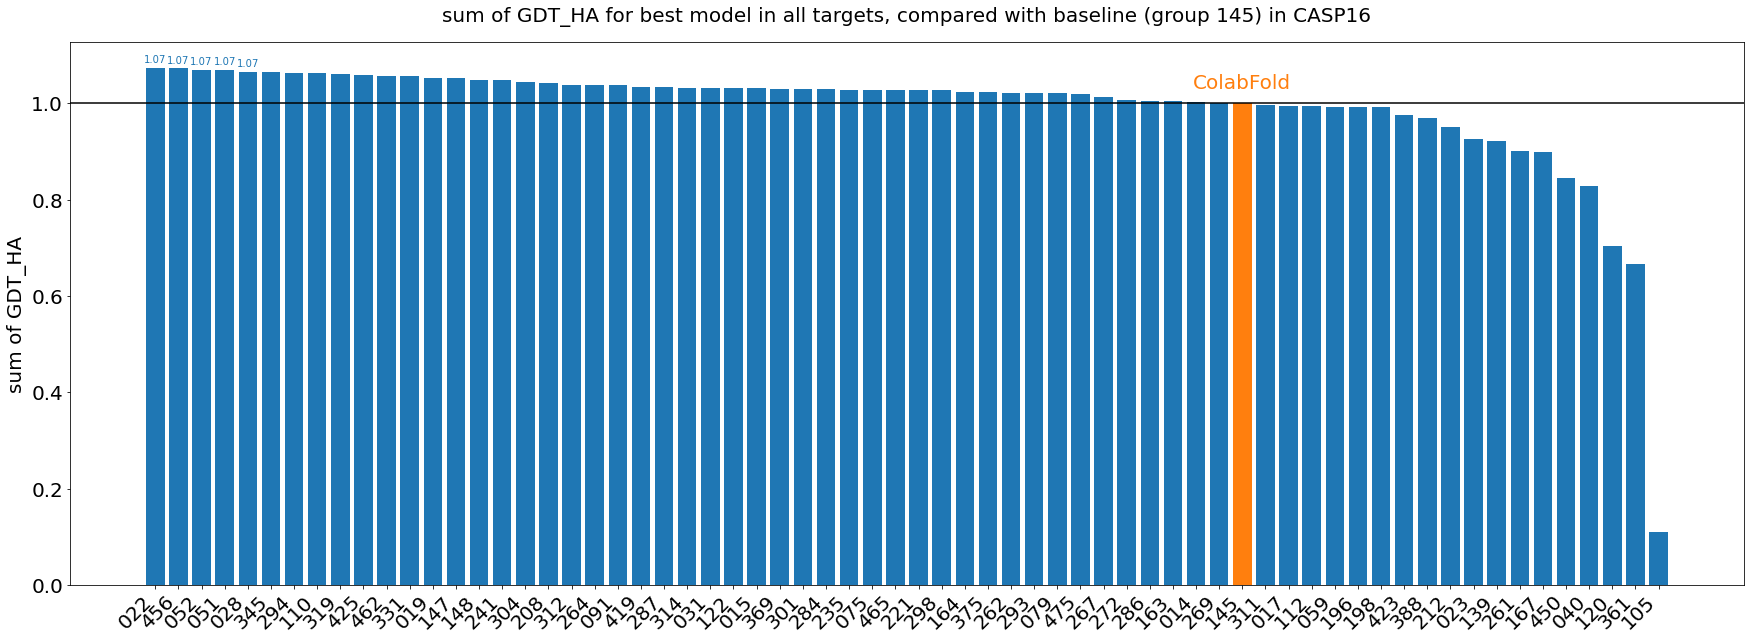

In [13]:
# sort the baseline_dict by its values
baseline_dict = dict(sorted(baseline_dict.items(),
                     key=lambda x: x[1], reverse=True))
groups = [key[2:] for key in baseline_dict.keys()]
values = list(baseline_dict.values())


plt.figure(figsize=(30, 10))
highlight_group = "145"
bar_colors = ['C0' if group != highlight_group else 'C1' for group in groups]
plt.bar(groups, values, color=bar_colors)
plt.xticks(rotation=45, fontsize=20, ha='right')
plt.yticks(fontsize=20)
plt.title(
    "sum of {} for {} model in {} targets, compared with baseline (group {}) in CASP16".format(feature, model, mode, highlight_group), fontsize=20, pad=20)
plt.ylabel("sum of {}".format(feature), fontsize=20)
plt.axhline(y=1, color='k')
# there is one group 145, we need to write something on top of its bar
for group, value in zip(groups, values):
    if group == highlight_group:
        plt.text(group, value + 0.03, str("ColabFold"),
                 ha='center', fontsize=20, color='C1')
# first 5 groups
first_5_groups = groups[:5]
first_5_values = values[:5]
for group, value in zip(first_5_groups, first_5_values):
    plt.text(group, value + 0.01, str(value.round(2)),
             ha='center', fontsize=10, color='C0')
plt.savefig(
    png_path + "sum_intersect_{}-{}-{}_with_colabfold_baseline.png".format(feature, model, mode), dpi=300)

In [14]:
file = "./group_by_target_CASP15/GDT_HA-best-all-raw.csv"
GDT_HA_data = pd.read_csv(file, index_col=0)
GDT_HA_data

,T1104-D1,T1106s1-D1,T1106s2-D1,T1109-D1,T1110-D1,T1112-D1,T1113-D1,T1114s1,T1114s1-D1,T1114s1-D2,...,T1184-D1,T1185s1-D1,T1185s2-D1,T1185s4-D1,T1187-D1,T1188-D1,T1194-D1,T1195-D1,T1196-D1,T1197-D1
TS003,79.06,70.07,84.69,84.23,92.31,62.28,80.84,32.20,65.00,49.77,...,88.6,80.15,69.73,77.89,86.89,86.04,96.12,48.10,51.68,69.08
TS006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.38,16.25,12.96,...,NaN,NaN,NaN,NaN,NaN,NaN,4.66,5.23,NaN,5.34
TS008,73.08,53.88,81.98,83.64,89.59,61.14,84.58,30.00,62.08,46.36,...,87.4,79.05,55.35,71.58,81.25,84.64,95.34,48.65,55.17,61.16
TS011,NaN,55.98,82.21,83.88,88.69,58.26,68.41,30.88,59.59,47.95,...,88.0,79.05,55.35,74.14,80.79,84.20,95.65,46.48,51.39,68.89
TS014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.28,51.38,68.13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TS481,88.46,57.40,80.41,84.70,89.48,63.04,65.27,31.03,68.75,48.18,...,90.0,79.78,56.23,73.40,81.86,85.65,94.56,48.28,53.79,62.31
TS488,37.82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TS493,NaN,70.42,84.23,82.59,88.92,NaN,69.91,NaN,NaN,NaN,...,87.2,NaN,NaN,NaN,80.33,NaN,NaN,NaN,NaN,NaN
TS494,NaN,70.77,83.56,84.93,90.72,60.92,78.44,48.68,85.00,75.23,...,88.8,79.41,68.61,77.35,82.32,83.68,NaN,NaN,NaN,NaN


In [15]:
GDT_HA_data = GDT_HA_data[GDT_HA_data.isna().sum(axis=1) < 0.5 * GDT_HA_data.shape[1]]
# print(data_raw.isna().sum(axis=0)/data_raw.shape[0])
# print(data_raw.isna().sum(axis=1)/data_raw.shape[1])
# for each row, get its non-nan values in intersection with "TS145", and calculate the sum of the non-nan values
# then divide the sum of the non-nan values by the sum of "TS145" to get the normalized sum
# then plot the normalized sum
GDT_HA_data = GDT_HA_data.T

groups = GDT_HA_data.columns
baseline_group = pd.DataFrame(GDT_HA_data["TS446"])
baseline_dict = {}
for group in groups:
    data_raw_group = pd.DataFrame(GDT_HA_data[group])
    # get the intersection of non nan values in data_raw_group and baseline_group
    non_nan_baseline = baseline_group[pd.notna(baseline_group["TS446"])].index
    non_nan_group = data_raw_group[pd.notna(data_raw_group[group])].index
    # 计算两者的交集
    intersection_index = non_nan_baseline.intersection(non_nan_group)
    # 根据 intersection_index 获取对应的值
    baseline_values = baseline_group.loc[intersection_index, "TS446"]
    group_values = data_raw_group.loc[intersection_index, group]

    # sum them up
    sum_baseline = baseline_values.sum()
    sum_group = group_values.sum()
    ratio = sum_group / sum_baseline
    baseline_dict[group] = ratio
    # # 输出结果或进行进一步操作
    # print(
    #     f"Group {group} has {len(intersection_index)} intersecting non-NaN values.")
    # print("Baseline values:", baseline_values.values)
    # print(f"{group} values:", group_values.valu

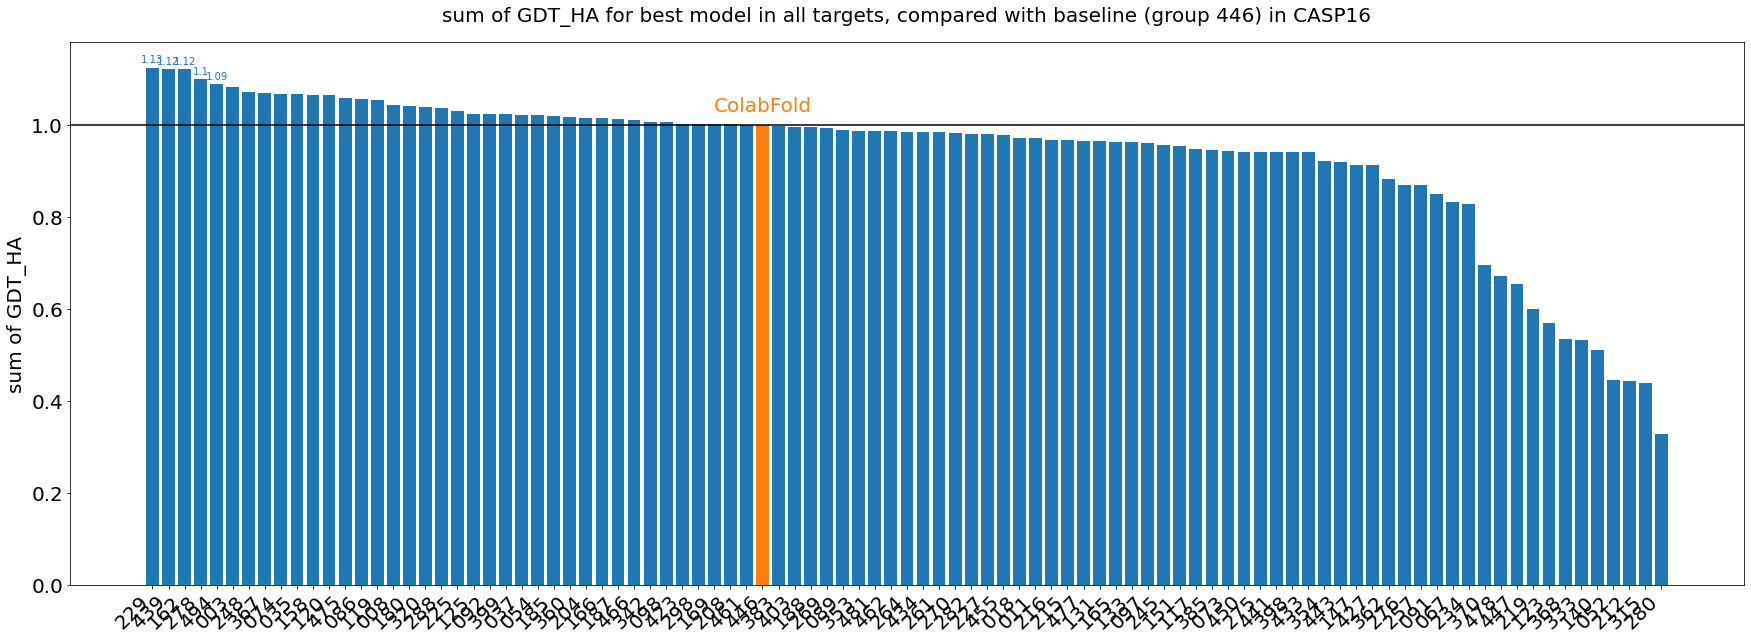

In [16]:
# sort the baseline_dict by its values
baseline_dict = dict(sorted(baseline_dict.items(),
                     key=lambda x: x[1], reverse=True))
groups = [key[2:] for key in baseline_dict.keys()]
values = list(baseline_dict.values())


plt.figure(figsize=(30, 10))
highlight_group = "446"
bar_colors = ['C0' if group != highlight_group else 'C1' for group in groups]
plt.bar(groups, values, color=bar_colors)
plt.xticks(rotation=45, fontsize=20, ha='right')
plt.yticks(fontsize=20)
plt.title(
    "sum of {} for {} model in {} targets, compared with baseline (group {}) in CASP15".format(feature, model, mode, highlight_group), fontsize=20, pad=20)
plt.ylabel("sum of {}".format(feature), fontsize=20)
plt.axhline(y=1, color='k')
# there is one group 145, we need to write something on top of its bar
for group, value in zip(groups, values):
    if group == highlight_group:
        plt.text(group, value + 0.03, str("ColabFold"),
                 ha='center', fontsize=20, color='C1')
# first 5 groups
first_5_groups = groups[:5]
first_5_values = values[:5]
for group, value in zip(first_5_groups, first_5_values):
    plt.text(group, value + 0.01, str(value.round(2)),
             ha='center', fontsize=10, color='C0')
plt.savefig(
    png_path + "sum_intersect_{}-{}-{}_with_colabfold_baseline.png".format(feature, model, mode), dpi=300)